In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

## Read in Keck pupil

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [6]:
screen1 = np.zeros(pupil.pupil.shape)

making full raw image


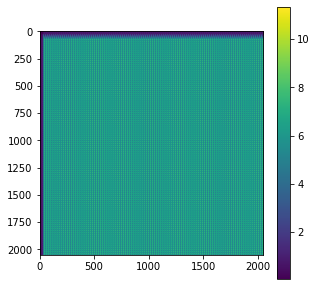

4.516212181250254
making full raw image


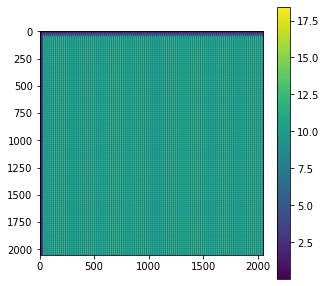

1.4104465007781983
making full raw image


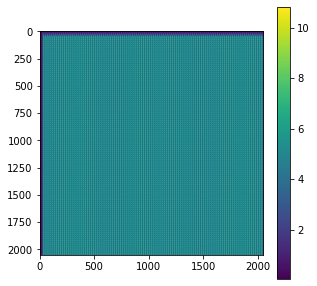

2.7520832975705463
making full raw image


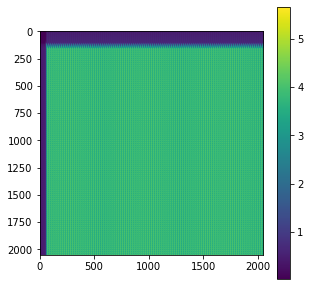

28.4193896373113
making full raw image


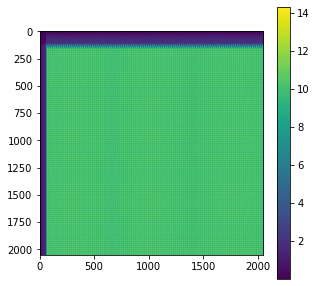

6.259893361727396
making full raw image


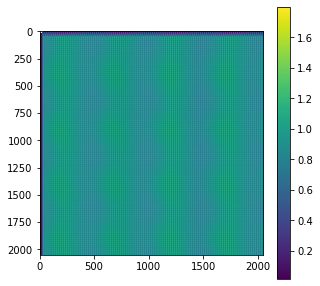

37.83908808231354


In [7]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs
    arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
    arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns
    
    lens = Lenslet(arg_spaxel)
    lens.get_shifts()
    lens.make_trace(phys=True,disp=True,verbose=True)
    
    nspax = arg_spaxel['no_spaxel']
    nlam = lens.trace.shape[0]

    keck_cube = np.zeros((nlam, nspax, nspax))
    mag1 = magn(lens.lmin)
    mag2 = magn(lens.lmax)

    psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
    if os.path.isfile(psf_file)==False:
        for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
            W = DFT_matrix(1600, mag)
            A = pupil.pupil * np.exp(1.j * screen1)
            out = abs(W.dot(A).dot(W))**2
            out /= np.sum(out, axis=(0,1))
            keck_cube[i] = frebin(out, (108, 108))
        fits.writeto(psf_file,np.array(keck_cube),clobber=True)
    else: keck_cube = pyfits.getdata(psf_file)

    vapor = 1 #PWV in mm
    airmass = 1 
    skybg = SkyBG(vapor,airmass)
    skytrans = SkyTrans(vapor,airmass)
    atmodisp = AtmoDispersion(90,20,600)

    telAO_emissivities = [0.4]
    telAO_temps = [285*u.K]
    scales_trans = [0.616]
    inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
    qe = QE(0.88) ##detector 6 is ~0.8, detector 8 is 0.88 -- testing "worst case" for saturation using detector 8
    
    
    filt = Filter(lmin=lens.lmin,lmax=lens.lmax,fkw='asahi')
    dit = 1 ###integration time in seconds
    
    ####organize all these and pass to focal_plane 
    args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
    fp = FocalPlane(args_new)
    
    from time import time
    t1 = time()
    raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,PSF=keck_cube,return_phots=True)
    rawfile = 'skyonly_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_phot_s.fits'
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
    rawfile = 'skyonly_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    pyfits.writeto(rawfile,np.array(raw*0.8),clobber=True)
    

    f = plt.figure(figsize=(5,5))
    plt.imshow(raw**0.25)
    plt.colorbar()
    plt.show()
    t2 = time()
    print((t2-t1)/60.0)

In [8]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs
    rawfile = 'skyonly_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    img = pyfits.getdata(rawfile)
    print(wav_min,wav_max)
    print(np.max(img))
    print(np.min(img[300:,300:]))
    print('------------------------')

2.9 4.15
13232.017246303978
38.2332170962697
------------------------
2.0 5.2
91956.56902795553
90.37046137687378
------------------------
2.0 4.0
10940.095912904242
3.629615065795434
------------------------
3.1 3.5
815.9003467695524
17.00290168903878
------------------------
4.5 5.2
33653.40924267234
545.2662336782614
------------------------
1.95 2.45
8.389727983680494
0.021879389032511413
------------------------
